# Data preprocess

In [1]:
import numpy as np
import re
import pandas as pd
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# 파일 불러와서 약간의 전처리

files = open("/content/drive/My Drive/Colab Notebooks/ai_school/data/par_corp.csv")

re_lines = []
for line in files:
    if line[0] == '[': # '[1], [2], ...' 의 형태로 된 인덱스 행들을 스킵한다.
        continue
    re_line = re.sub('[#".?!\n]', '', line)
    re_lines.append(re_line)

print(re_lines[:4]) # [영어, 한글, 영어, 한글, ...]

['The order went forth that', '명령은 아래와 같이 반포되었다', 'The orders must be strictly obeyed', '명령은 반드시 엄격히 준수해야 한다']


In [4]:
kor = []
eng = []
count = 0

for line in re_lines:
    count = count + 1
    if count % 2 == 0:
        kor.append(line) # 짝수는 한글 -> kor 리스트에 추가
    else:
        eng.append(line) # 홀수는 영어 -> eng 리스트에 추가

d = {'kor':kor, 'eng':eng} # kor, eng 리스트를 딕셔너리 형태로 변환

par_corp = pd.DataFrame(d) # 딕셔너리를 데이터 프레임으로 변환

print(par_corp)

                          kor                                        eng
0            명령은 아래와 같이 반포되었다                  The order went forth that
1         명령은 반드시 엄격히 준수해야 한다         The orders must be strictly obeyed
2       운명의 여신은 용사를 특별히 애호하신다                  fortune favors the brave 
3         운명에 그가 죽을 것이라고 정해졌다            Fate destined that he shall die
4      운명에 그는 목사가 될 것이라고 정해졌다         Fate had ordained him to die young
...                       ...                                        ...
47662              사자는 야생동물이다                  The lion is a wild animal
47663            사자는 황야로 도망갔다  The lion escaped and returned to the wild
47664   사자는 우리 안에서 천천히 왔다갔다한다       The lion paced the floor of its cage
47665   젖은 셔츠가 그의 몸에 착 달라붙어있다            The wet shirt clung to his body
47666      젖은 성냥은 그어도 켜지지 않는다                  Damp matches won't strike

[47667 rows x 2 columns]


In [5]:
# 문장 토큰화 (스탑워드 제거) -> 단어 별로 나누기 위해서
# 정수 인코딩 -> 컴퓨터가 잘 알아들을수 있도록 단어로 된거를 숫자로 변형
# 패딩 -> embedding layer를 통과하려면 벡터의 길이가 같아야하기 때문에

# '<start> i am taking a walk with my dog'
# -> 각 시점마다 이 문장의 일부분을 decoder_output을 추측하는데 사용하고 있음
# 'i am taking a walk with my dog <end>'

encoder_input, decoder_input, decoder_output = [], [], []

# 왜 디코더는 인풋/아웃풋 둘 다 존재하는가?
# 예를 들어, '나는 개와 산책을 하고 있다'라는 문장이 있을 때 -> 인코더를 거치면서 셀/은닉 상태 리턴
# 위 문장의 '셀 상태'와 '은닉 상태' + '<start>' 가 인풋으로 들어가면,
# 지금까지 쌓아진 셀/은닉 상태 값, 현재 단어 출력 -> 다음 단어 예측에 사용
# 여기서 <start>가 예측한 단어는 <start> 바로 다음 단어 (예측 문장의 첫 단어)

# 훈련을 시키고나서 예측을 하려고 할 때 (상태값이 없다면) <start> 뒤에는 굉장히 다양한 단어가 올 수 있음
# <start> 는 뒤에 어떤 단어든지 올 수 있는 단어의 역할
# 상태값을 함께 고려하도록 해주면, 모든 단어들 중에서 상태값에 연관되어있는 것만 높을 확률을 부여
# 그렇게 예측한 바로 전 단어를 기준으로 다음 단어의 예측을 반복
# 다음 단어로 <end>가 예측된다면, 이제 그만 예측하라는 뜻

# '<start> i am taking a walk with my dog'
# -> 각 시점마다 이 문장의 일부분을 decoder_output의 일부분을 추측하는데 사용하고 있음
# 'i am taking a walk with my dog <end>'

for stc in par_corp['kor']:
    encoder_input.append(stc.split())

# 스타트 뒤에 띄어쓰기 :<start>도 split 해줘야 하기 때문
# ex) ['<start>', 'i', 'am', 'taking']
for stc in par_corp['eng']:
    decoder_input.append(("<start> "+stc).split())

# 엔드도 스타트와 마찬가지
for stc in par_corp['eng']:
    decoder_output.append((stc+" <end>").split())

In [6]:
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[['명령은', '아래와', '같이', '반포되었다'], ['명령은', '반드시', '엄격히', '준수해야', '한다'], ['운명의', '여신은', '용사를', '특별히', '애호하신다']]
[['<start>', 'The', 'order', 'went', 'forth', 'that'], ['<start>', 'The', 'orders', 'must', 'be', 'strictly', 'obeyed'], ['<start>', 'fortune', 'favors', 'the', 'brave']]
[['The', 'order', 'went', 'forth', 'that', '<end>'], ['The', 'orders', 'must', 'be', 'strictly', 'obeyed', '<end>'], ['fortune', 'favors', 'the', 'brave', '<end>']]


In [7]:
tokenizer_ko = Tokenizer()
tokenizer_ko.fit_on_texts(encoder_input)
encoder_input = tokenizer_ko.texts_to_sequences(encoder_input)

# 만약에 Tokenizer(5000)이면, 1~4999(패딩하기 전) -> 0~4999(패딩하고 난 뒤)
# 즉, 빈도수 순서로 1~4999 까지의 인덱스를 부여한 후, 남는 길이만큼 0을 채운다.
tokenizer_en = Tokenizer()
tokenizer_en.fit_on_texts(decoder_input)
tokenizer_en.fit_on_texts(decoder_output)
# 정수 인코딩 (1부터 인덱스를 부여하는 부분)
decoder_input = tokenizer_en.texts_to_sequences(decoder_input)
decoder_output = tokenizer_en.texts_to_sequences(decoder_output)

In [8]:
# 2와 3이 start와 end 역할을 하는 것을 확인 할 수 있다.
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[[10325, 1216, 312, 23138], [10325, 66, 8026, 6543, 12], [8027, 23139, 23140, 1162, 23141]]
[[2, 1, 175, 97, 670, 19], [2, 1, 761, 78, 31, 2133, 11983], [2, 1324, 6699, 1, 2852]]
[[1, 175, 97, 670, 19, 3], [1, 761, 78, 31, 2133, 11983, 3], [1324, 6699, 1, 2852, 3]]


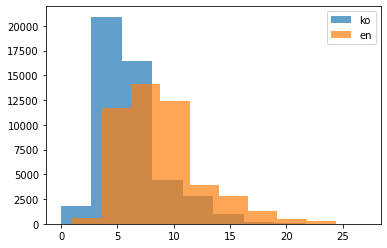

In [9]:
# 문장 길이 체크
import matplotlib.pyplot as plt

len_ko = []
for data in encoder_input:
    len_ko.append(len(data))

len_en = []
for data in decoder_input:
    len_en.append(len(data))

plt.hist(len_ko, label='ko', alpha=0.7)
plt.hist(len_en, label='en', alpha=0.7)
plt.legend()
plt.show()

In [10]:
# maxlen을 굳이 명시하지 않아도 알아서 잘 해준다.
# padding="post" -> 문장은 단어가 이어지는게 중요하기 때문에 앞에서 부터 단어를 넣고 뒤에 0을 채우도록 해준다.
encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_output = pad_sequences(decoder_output, padding="post")

In [11]:
# 실제 최대 길이인 27에 맞춰진 것을 확인 가능
print(encoder_input.shape)
print(decoder_input.shape)

(47667, 27)
(47667, 27)


In [12]:
# 나중에 prediction 할때 사용하기 위함 (인덱스로 단어 찾기)
en_to_index = tokenizer_en.word_index
index_to_en = tokenizer_en.index_word

In [13]:
# 훈련, 테스트 데이터 나누기
test_size = 12000 # 총 데이터가 47667개 아므로, 약 3대 1의 비율

encoder_input_train = encoder_input[:-test_size]
decoder_input_train = decoder_input[:-test_size]
decoder_output_train = decoder_output[:-test_size]

encoder_input_test = encoder_input[-test_size:]
decoder_input_test = decoder_input[-test_size:]
decoder_output_test = decoder_output[-test_size:]

# Training

In [14]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [15]:
# 인코더 모델 - 한글 문장 받아서 LSTM 마지막 시점의 은닉상태/셀상태 리턴하도록

# 원래는 데이터 갯수랑 문장 길이 같이 들어가야하지만, 왜 여기선 데이터 갯수는 명시하지 않을까?
# 그 이유는, fit 할때 validation data -> test set -> 데이터 갯수 다르기 때문에
encoder_inputs = Input(shape=(27,)) # 27은 문장의 길이

# 1을 더해주는 이유는 패딩하면서 생긴 0을 처리해주기 위함
# 예를 들어, Tokeninzer(5000)은 1 부터 4999 까지 인덱스 부여하기 때문
encoder_embed = Embedding(len(tokenizer_ko.word_index)+1, 50)(encoder_inputs)

# 사실 패딩 값은 필요없다. (0에 해당하는 임베딩 벡터 제외)
encoder_mask = Masking(mask_value=0)(encoder_embed)

# return_state=True 를 쓰면 '마지막 은닉 상태', '마지막 은닉 상태', '마지막 셀 상태'의 총 3개 리턴
# LSTM 셀 자체에서 한 시점의 출력은 은닉 상태값 (softmax 함수를 통과하면서 y값)
# encoder_outputs는 마지막 은닉 상태 값, h_state도 마지막 은닉 상태 값, 즉 encoder_outputs == h_state
encoder_outputs, h_state, c_state = LSTM(50, return_state=True)(encoder_mask)

In [16]:
# 디코더 모델 - 위에서 리턴한 상태값(h_state, c_state)과 영어 문장 입력받아서
# LSTM이 출력한 값(은닉 상태)을 받아서 softmax 함수를 통과시키도록

decoder_inputs = Input(shape=(27,)) # 27은 영어 문장의 길이
decoder_embed = Embedding(len(tokenizer_en.word_index)+1, 50)(decoder_inputs)
decoder_mask = Masking(mask_value=0)(decoder_embed)

# return_sequences=True 를 쓰면 전체 시점의 은닉 상태 값을 리턴 -> 각 단어 인풋 별로 나오는 은닉 상태값
# return_state=True 까지 둘 다 쓰면, 전체 시점의 은닉 상태(단어 갯수 만큼) / 마지막 은닉 상태 / 마지막 셀 상태 값을 리턴
# -> 훈련 땐 필요 없지만, Prediction에서 다음 단어 예측을 위해 return_state도 True로 설정한다.
decoder_lstm = LSTM(50, return_sequences=True, return_state=True)

# decoder_outputs는 전체 시점의 은닉 상태 값
# decoder는 마지막 시점의 은닉/셀 상태 값이 중요하지 않기 때문에 _로 처리
# initial_state : 인코더의 마지막 은닉/셀 상태 값이 디코더의 초기 상태 값으로 입력
decoder_outputs, _, _ = decoder_lstm(decoder_mask, initial_state=[h_state, c_state]) 

# 전체 단어중 가장 높은 확률값을 얻어야해서, 임베딩과 동일하게 0을 고려하여 인덱스의 수에 1을 더해 전체 단어 갯수만큼 차원을 설정 
# 패딩을 한 후의 지금 0 ~ 단어 갯수 -> 수를 가진 decoder_input/output
# [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..., 단어 갯수 만큼] -> array
# [0번째 인덱스의 단어가 다음단어일 확률, 1번째 인덱스의 단어가 다음단어일 확률, 0.2, 0.3, ..., 단어 갯수] (지금 input으로 들어간 단어의 다음 단어일 확률값)
decoder_dense = Dense(len(tokenizer_en.word_index)+1, activation='softmax') # 각각의 단어일 확률들이 쭉 나온다.
decoder_softmax_outputs = decoder_dense(decoder_outputs)

In [17]:
# 컴파일 진행

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

# sparse는 라벨이 정수 형태로 제공될 때 사용되는 함수 (그냥 categorical은 원핫 벡터로 라벨이 제공될 때)
# 손실 함수에 sparse_ 를 쓰면 각각의 정수 인코딩 그대로 / 그냥 categorical_은 원 핫 인코딩으로 다시 변환
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

# 모델 자체가 아닌 레이어 별로 가중치가 학습되는 것이다. (예측에서 다시 학습할 필요 X)
model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_output_train, validation_data = ([encoder_input_test, decoder_input_test], decoder_output_test), batch_size = 128, epochs = 10)

Epoch 1/10
279/279 [==============================] - 63s 226ms/step - loss: 3.4303 - acc: 0.6887 - val_loss: 2.2802 - val_acc: 0.6918
Epoch 2/10
279/279 [==============================] - 61s 220ms/step - loss: 1.9869 - acc: 0.7287 - val_loss: 2.1965 - val_acc: 0.6973
Epoch 3/10
279/279 [==============================] - 61s 220ms/step - loss: 1.9184 - acc: 0.7369 - val_loss: 2.1419 - val_acc: 0.7042
Epoch 4/10
279/279 [==============================] - 62s 221ms/step - loss: 1.8634 - acc: 0.7407 - val_loss: 2.1040 - val_acc: 0.7058
Epoch 5/10
279/279 [==============================] - 62s 221ms/step - loss: 1.8186 - acc: 0.7432 - val_loss: 2.0643 - val_acc: 0.7092
Epoch 6/10
279/279 [==============================] - 62s 221ms/step - loss: 1.7767 - acc: 0.7464 - val_loss: 2.0258 - val_acc: 0.7125
Epoch 7/10
279/279 [==============================] - 62s 221ms/step - loss: 1.7351 - acc: 0.7518 - val_loss: 2.0018 - val_acc: 0.7156
Epoch 8/10
279/279 [==============================] - 6

# Prediction

In [18]:
# 인코더가 출력하는 마지막 시점의 셀/은닉 상태 값 따로 구하고
# <start> 라는 인풋을 따로 디코더 모델의 LSTM에 집어넣은 후,
# LSTM에서 나오는 아웃풋을 다시 LSTM에 계속 집어넣는 형태로 반복
# 그러다가 <end>가 보이면 예측 중단

In [19]:
# 인코더가 출력하는 마지막 시점의 셀/은닉 상태 값을 따로 구하고, h_state, c_state는 아웃풋 레이어 (LSTM) 를 명시한 것
# encoder_inputs과 encoder_input는 서로 다른 것 / encoder_inputs , h_state, c_state는 위에서 명시했던 것 사용
# 훈련을 하고 나면 레이어 별로 가중치를 학습하기 때문에, 이미 훈련으로 학습된 가중치를 가진 레이어를 그대로 사용 
encoder_model = Model(encoder_inputs, [h_state, c_state])

In [20]:
# 디코더 모델을 만드는데, 디코더 모델에 초기값으로 넣을 상태값의 모양을 지정
encoder_h_state = Input(shape=(50,))
encoder_c_state = Input(shape=(50,))

# 우리가 시퀀스를 넣을게 아니라 단어단어를 넣을거기 때문에, 시점이 여러개가 아니라 한 시점만 존재
# 상태값을 자동으로 넘겨주지 않기 때문에 (순환 X), 직접 넘겨줘야한다. -> 셀 마다마다 상태의 초기값을 지정, 나오는 상태값을 저장
pd_decoder_outputs, pd_h_state, pd_c_state = decoder_lstm(decoder_mask, initial_state=[encoder_h_state, encoder_c_state])
pd_decoder_softmax_outputs = decoder_dense(pd_decoder_outputs)

# 모델은 디코더 인풋 (<start>) 과 인코더의 상태값이 인풋으로 들어간다.
# LSTM 셀 통과하면서 예측하여 'softmax 함수를 통과한 출력값 (각 단어별 다음 단어일 확률값)', '디코더의 상태값' 두 개를 출력하는 것
# softmax 함수를 통과한 출력값 (확률) 을 토대로 다음 단어를 확정
# 다시 그 단어를 디코더 인풋으로 + 전 시점의 디코더의 상태값이 인풋으로 들어간다.
decoder_model = Model([decoder_inputs] + [encoder_h_state, encoder_c_state], [pd_decoder_softmax_outputs] + [pd_h_state, pd_c_state])

In [21]:
# '한글 문장 -> 영어 문장' 예측 (학습이 부족하여 정확도가 매우 낮음)

input_stc = input()
token_stc = input_stc.split()
encode_stc = tokenizer_ko.texts_to_sequences([token_stc])
pad_stc = pad_sequences(encode_stc, maxlen=27, padding="post")

# 인코더의 마지막 시점의 셀/은닉 상태 값
states_value = encoder_model.predict(pad_stc)

# <start> 를 정수 인코딩해서 numpy array 로
predicted_seq = np.zeros((1,1))
predicted_seq[0, 0] = en_to_index['<start>']

# 각 시점마다 예측된 단어를 저장
decoded_stc = []

while True:
    output_words, h, c = decoder_model.predict([predicted_seq] + states_value)

    predicted_word = index_to_en[np.argmax(output_words[0,0])]  

    if predicted_word == '<end>':
        break

    decoded_stc.append(predicted_word)

    # 처음에는 <start>, 지금은 예측된 단어가 있으니 이것을 인풋으로 넣어주기 위해서 변수의 값을 업데이트
    predicted_seq = np.zeros((1,1))
    predicted_seq[0, 0] = np.argmax(output_words[0,0])

    # 지금 시점의 상태 값을 다음 시점으로 넘기기 위해서 변수를 업데이트
    # WARNING이 나오는 이유는, Prediction은 단어를 하나씩 넣으며 다음 단어를 예측하는데 27로 설정한 모델을 그대로 사용했기 때문
    states_value = [h, c]

print(' '.join(decoded_stc))

오늘은 날씨가 좋다
the door is a good
